# Box Office Growth

<img src="images/videoproduction.jpg" width="500" alt="Business Opportunity" />

## Overview

Our client is a company that is interested in creating original video content through creation of a new movie studio, and wants to determine which types of films will be most successful in this new enterprise. This project analyses movie popularity data and box office revenues from multiple online databases to identify the most promising types of movies to be slated for initial rounds of production.

## Business Problem

The company wants to direct its resources towards creating new movie content that is popular and profitable. We will leverage these databases to identify the trends in recently popular movie genres through rating data, and pinpoint those genres that lead to large revenue streams and signficant return on investment for their production budgets.

## Data Understanding

For this analysis, we will make use of the Internet Movie DataBase ([IMDB](https://www.imdb.com/)), a SQLite database containing tables of movie data, including genre, rating, year, and individuals involved in production. We will preprocess the data to extract movie popularity metrics (number of reviews, average reviews) by genre to identify promising movie genres.

Additionally, we will analyze box office revenue databases from [The Numbers](https://www.the-numbers.com/) and [Box Office Mojo](https://www.boxofficemojo.com/), to identify which genres led to the greatest revenue and return on investment from the production budget.

<img src="images/movietheater.jpg" width="500" alt="Movie ratings data" />

#### Limitations of This Dataset

We are making a best-use analysis of the data we have at hand, which are movies that have been entered with reviews into these databases. This may not be reflective of all movies on the market, but we will draw relative conclusions by comparing among genres for those films who have ratings in these databases.

Additionally, while the rating data encompases many movies, only a subset of those films are included with box office revenue and production budgets, so our conclusions on profitability of films is drawn from this smaller data set.

In [1]:
#import necessary packages for analysis and visualization
import pandas as pd
import numpy as np
import sqlite3
import gzip
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

#### The Numbers database

In [2]:
#load The Numbers dataset (budgets and gross revenue)
df_TN = pd.read_csv('data/tn.movie_budgets.csv.gz', index_col=0)

#print the columns and the first 5 entries
df_TN.info()
df_TN.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5782 entries, 1 to 82
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   release_date       5782 non-null   object
 1   movie              5782 non-null   object
 2   production_budget  5782 non-null   object
 3   domestic_gross     5782 non-null   object
 4   worldwide_gross    5782 non-null   object
dtypes: object(5)
memory usage: 271.0+ KB


,release_date,movie,production_budget,domestic_gross,worldwide_gross
id,,,,,
1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


___

#### Box Office Mojo database

In [3]:
#load Box Office Mojo dataset (gross revenues)
df_BOM = pd.read_csv('data/bom.movie_gross.csv.gz')

#print the columns and the first 5 entries
df_BOM.info()
df_BOM.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


#### IMDB database (SQLite tables)

In [4]:
#load IMDB SQLite database and print out TABLE & COLUMN Names
conn = sqlite3.connect('data\im.db') 
curr = conn.cursor() 

#get table names from db
q = """SELECT name FROM sqlite_master WHERE type='table';""" 
curr.execute(q) 
table_list = curr.fetchall()
table_names = []
for item in table_list:
    table_names.append(item[0])

#print out column names from each table
for name in table_names: #loop over tables
    print('**Table:**  ' + name)
    q = """SELECT * FROM """ + name
    curr.execute(q)
    print('Columns:  ')
    for desc in curr.description: #loop over column names
        print(desc[0])
    print(' \n')

**Table:**  movie_basics
Columns:  
movie_id
primary_title
original_title
start_year
runtime_minutes
genres
 

**Table:**  directors
Columns:  
movie_id
person_id
 

**Table:**  known_for
Columns:  
person_id
movie_id
 

**Table:**  movie_akas
Columns:  
movie_id
ordering
title
region
language
types
attributes
is_original_title
 

**Table:**  movie_ratings
Columns:  
movie_id
averagerating
numvotes
 

**Table:**  persons
Columns:  
person_id
primary_name
birth_year
death_year
primary_profession
 

**Table:**  principals
Columns:  
movie_id
ordering
person_id
category
job
characters
 

**Table:**  writers
Columns:  
movie_id
person_id
 



---

# Data Preparation

### Data Cleaning

We will drop entries from the Box Office Mojo Database that have a null entry for Domestic Gross.

In The Numbers database, revenue and budgets will be converted to float values, and release date will be converted to integer year values, to be consistent with the Box Office Mojo Database.

Movie titles in both will be converted to lowercase, to aid registration with the IMDB data later.

In [5]:
## PREPROCESS Box Office Mojo database

# drop irrelevant columns
df_BOM = df_BOM.drop(columns=['studio'])

# convert title to lowercase
df_BOM['title'] = df_BOM['title'].apply(lambda x: x.lower())

# convert foreign gross from string to float (had to format as string first to avoid differing datatypes)
df_BOM['foreign_gross'] = df_BOM['foreign_gross'].apply(lambda x: float(str(x).replace(',','')))

# add production_budget column and insert NaN values (to align structure with The Numbers database below)
df_BOM['production_budget'] = np.nan

df_BOM


,title,domestic_gross,foreign_gross,year,production_budget
0,toy story 3,415000000.0,652000000.0,2010,NaN
1,alice in wonderland (2010),334200000.0,691300000.0,2010,NaN
2,harry potter and the deathly hallows part 1,296000000.0,664300000.0,2010,NaN
3,inception,292600000.0,535700000.0,2010,NaN
4,shrek forever after,238700000.0,513900000.0,2010,NaN
...,...,...,...,...,...
3382,the quake,6200.0,NaN,2018,NaN
3383,edward ii (2018 re-release),4800.0,NaN,2018,NaN
3384,el pacto,2500.0,NaN,2018,NaN
3385,the swan,2400.0,NaN,2018,NaN


In [6]:
## PREPROCESS The Numbers database

# loop over the fields below and convert from string to float, removing formatting
fields = ['production_budget','domestic_gross','worldwide_gross']
for field in fields:
    df_TN[field] = df_TN[field].apply(lambda x: float(x[1:].replace(',','')))
    
# convert movie titles to lowercase
df_TN['title'] = df_TN['movie'].apply(lambda x: x.lower())

# convert release dates to integer years
df_TN['year'] = df_TN['release_date'].apply(lambda x: int(x[-4:]))

# calculate foreign gross by subtracting domestic from worldwide gross
df_TN['foreign_gross'] = df_TN['worldwide_gross'] - df_TN['domestic_gross']

## keep columns to be consistent with Box Office Mojo database
df_TN_clean = df_TN[['title','domestic_gross','foreign_gross','year','production_budget']]


In [7]:
df_TN_clean

,title,domestic_gross,foreign_gross,year,production_budget
id,,,,,
1,avatar,760507625.0,2.015838e+09,2009,425000000.0
2,pirates of the caribbean: on stranger tides,241063875.0,8.046000e+08,2011,410600000.0
3,dark phoenix,42762350.0,1.070000e+08,2019,350000000.0
4,avengers: age of ultron,459005868.0,9.440081e+08,2015,330600000.0
5,star wars ep. viii: the last jedi,620181382.0,6.965404e+08,2017,317000000.0
...,...,...,...,...,...
78,red 11,0.0,0.000000e+00,2018,7000.0
79,following,48482.0,1.920130e+05,1999,6000.0
80,return to the land of wonders,1338.0,0.000000e+00,2005,5000.0


In [8]:
# concatenate all the revenue data into 1 dataframe
df_rev = pd.concat([df_BOM, df_TN_clean], ignore_index=True)
df_rev

,title,domestic_gross,foreign_gross,year,production_budget
0,toy story 3,415000000.0,652000000.0,2010,NaN
1,alice in wonderland (2010),334200000.0,691300000.0,2010,NaN
2,harry potter and the deathly hallows part 1,296000000.0,664300000.0,2010,NaN
3,inception,292600000.0,535700000.0,2010,NaN
4,shrek forever after,238700000.0,513900000.0,2010,NaN
...,...,...,...,...,...
9164,red 11,0.0,0.0,2018,7000.0
9165,following,48482.0,192013.0,1999,6000.0
9166,return to the land of wonders,1338.0,0.0,2005,5000.0
9167,a plague so pleasant,0.0,0.0,2015,1400.0


---

### Feature Engineering

We will add a return-on-investment column (ROI) to the revenue database, calculated as `(domestic_gross - production_budget) / production_budget` where there are values for both, NaN otherwise. 

In [9]:
# calculate ROI value (domestic_gross - production_budget)/production_budget, where we have values
df_rev['roi'] = (df_rev['domestic_gross']-df_rev['production_budget'])/df_rev['production_budget']

# calculate domestic profit (domestic_gross - production_budget)
df_rev['domestic_profit'] = (df_rev['domestic_gross'] - df_rev['production_budget'])

From the IMDB database, we will join the tables `movie_basics` and `movie_ratings`to link genres to reviews. Since each movie can span multiple genres, we will encode movie genres by binary (0/1) entries in each genre column.

In [10]:
#sql query to join tables
q = """
SELECT * FROM movie_basics
JOIN movie_ratings
    USING(movie_id)
;"""

df = pd.read_sql(q, conn)


#collect unique list of genre names
genres = set() #define empty set
for labels in df.genres:
    if not(pd.isnull(labels)): #if entry isn't null
        genres = genres.union(set(labels.split(','))) #split string into genre names, take union with set of unique genres and store
genres = list(genres)
print('Genres: ')
print(genres)

df_genres = pd.DataFrame(columns=genres, index=range(df.shape[0])) #set columns for genres
df_genres.loc[:,:] = 0 #initialize flags to zero
df_genres['primary_title'] = df['primary_title'].apply(lambda x: x.lower()) #make title lowercase

column_keep = ['primary_title','movie_id','averagerating','numvotes','start_year']
df_genres[column_keep] = df[column_keep]


for i in range(df.shape[0]): # loop over entries
    genre_str = df['genres'].loc[i]
    if not(pd.isnull(genre_str)): #if not null
        genre_str = genre_str.split(',') #get list of genres
        for genre in genre_str: #loop over genres
            df_genres.loc[i, genre] = 1 #set genre flag to 1

df_genres['sumrating'] = df_genres['averagerating']*df_genres['numvotes'] #multiply average rating by number of votes to get summed rating
df_genres.head(5)



Genres: 
['Documentary', 'Adventure', 'Western', 'Adult', 'Biography', 'Music', 'Fantasy', 'Horror', 'Sport', 'News', 'Crime', 'Drama', 'Sci-Fi', 'Action', 'Musical', 'History', 'Reality-TV', 'Short', 'Animation', 'Game-Show', 'Comedy', 'Thriller', 'War', 'Romance', 'Mystery', 'Family']


,Documentary,Adventure,Western,Adult,Biography,Music,Fantasy,Horror,Sport,News,...,War,Romance,Mystery,Family,primary_title,movie_id,averagerating,numvotes,start_year,sumrating
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,Sunghursh,tt0063540,7.0,77,2013,539.0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,One Day Before the Rainy Season,tt0066787,7.2,43,2019,309.6
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,The Other Side of the Wind,tt0069049,6.9,4517,2018,31167.3
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,Sabse Bada Sukh,tt0069204,6.1,13,2018,79.3
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,The Wandering Soap Opera,tt0100275,6.5,119,2017,773.5


In [11]:
#save cleaned datasets as CSV files (after restricting to columns we care about)

df_rev.to_csv('./data/cleaned_df_rev.csv')
df.to_csv('./data/imdb_df.csv')
df_genres.to_csv('./data/df_genres.csv')

## Analysis

### Genre popularity and ratings over time
First we will look at the number of ratings by genre, to identify the most popular movie genres.

In [12]:
## define a function to return rating and movie counts, by genre:

def get_genre_ratings(df, genre_label, sortcol='movie_ct'):
    # inputs: df -- genre dataframe
    #         genre_label -- list of genre strings
    # returns: dataframe, with 1 column listing the genre_labels and columns listing the 
    #         # of ratings, # of movies
    
    genre_names=[] #initialize series to append each genre's data
    movie_ct=[]
    rating_ct=[]
    
    for genre in genre_label: #loop over genre labels
        df_subset = df[df[genre]==1] #find movies where this genre is flagged
        genre_names.append(genre) #add genre name
        movie_ct.append(df_subset[genre].sum()) #add movie counts
        rating_ct.append(df_subset['numvotes'].sum()) #add rating totals
        
    df_summary = pd.DataFrame(data={'genre': genre_names, 'movie_ct': movie_ct, 'rating_ct': rating_ct}) #create the data frame for output
    df_summary.sort_values(by=[sortcol], ascending=False, inplace=True)
    
    return df_summary



## define a function to plot the returned dataframe as a bar plot

def plot_genre_ratings(df_summary, nlimit=0, orderingcol='separate'):
    # inputs: df_summary -- summary dataframe of genre review coutns
    #         nlimit -- 0 [default] includes all entries, n>0 subselects to top n genres
    #         orderingcol -- 'separate' [default], orders the bar plots for movie_ct and rating_ct separately
    #                        'movie_ct', orders both movie_ct and rating_ct by movie_ct
    #                        'rating_ct', orders both movie_ct and rating_ct by rating_ct
    
    if orderingcol=='separate':
        df_movie = df_summary.sort_values(by=['movie_ct'], ascending=False)
        df_rating = df_summary.sort_values(by=['rating_ct'], ascending=False)
    else:
        df_movie = df_summary.sort_values(by=[orderingcol], ascending=False)
        df_rating = df_summary.sort_values(by=[orderingcol], ascending=False)
    
    if nlimit>0 & nlimit<df_summary.shape[0]: #if we're to limit entries to top N (and N is less than size of rows)
        df_movie = df_movie.iloc[:nlimit, :]
        df_rating = df_rating.iloc[:nlimit, :]
        
    fig, ax = plt.subplots(1, 2, figsize=(15,6))
    ax[0].bar(df_movie['genre'], df_movie['movie_ct'])
    ax[1].bar(df_rating['genre'], df_rating['rating_ct'])
    
    for axis in ax:
        axis.xaxis.set_tick_params(rotation=45)
        axis.set_xlabel('Genre')
        axis.set_ylabel('Count')
        
    ax[0].set_title('Total # of Unique Movies Rated (by Genre)')
    ax[1].set_title('Total # of Movie Ratings (by Genre)')
        
    return df_movie, df_rating, fig, ax

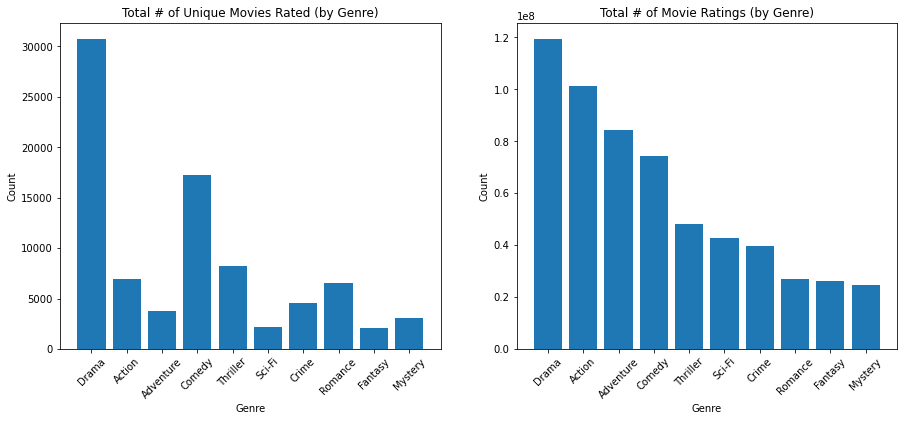

In [13]:
df_summary = get_genre_ratings(df_genres, genres)
df_summary

#plot_genre_ratings(df_summary, nlimit=10, orderingcol='separate')
df_movie, df_rating, fig, ax = plot_genre_ratings(df_summary, nlimit=10, orderingcol='rating_ct')

fig.savefig('./images/counts_by_genre.png')

In [14]:
df_rating

,genre,movie_ct,rating_ct
11,Drama,30788,119567500
13,Action,6988,101161682
1,Adventure,3817,84232589
20,Comedy,17290,74305805
21,Thriller,8217,48155313
12,Sci-Fi,2206,42960289
10,Crime,4611,39631356
23,Romance,6589,26913873
6,Fantasy,2126,26335704
24,Mystery,3039,24657286


#### Ratings Count by Genre

* From the above right plot, we can see that 4 genres have received the most total movie ratings: Drama, Action, Adventure, and Comedy.

* The above left plot shows that Drama and Comedy genres had the most unique movies, while Action and Adventure had less (suggesting fewer of those movies but more viewers going to attend them).

**Thus, we recommend our client company focus on producing movies from these 4 popular genres.**


Below, I will break down these ratings by average score and year to identify persistent trends.

In [15]:
# function to extract summary rating statistics from 1 genre
def get_genre_ratings_by_year(df, genre_label):
    # inputs: df -- genre dataframe
    #         genre_label -- one genre string
    # returns: group_dataframe, with 1 column listing the year and other columns listing the 
    #             summary statistics for the ratings across movies in that genre
    #             summary statistics columns are: [mean, sem, count]
    
    group = df[df[genre_label]==1].groupby('start_year').agg(mean=('averagerating','mean'),
                                                                    sem=('averagerating','sem'),
                                                                    count=('averagerating','count'))
    return group


# function to fit linear regression model parameters to yearly ratings for 1 genre
def get_rating_regression(df, genre_label):
    # inputs: df -- genre dataframe
    #         genre_label -- one genre string
    # returns: params -- paramters of linear regression fit [constant, year_coefficient]
    
    df = df[df[genre_label]==1]
       
    X = df['start_year']
    y = df['averagerating']
    model = sm.OLS(endog=y, exog=sm.add_constant(X))
    model_results = model.fit()
    
    return model_results.params


# function to plot 1 genre's summary rating statistics alongside a regression line fit
def plot_genre_ratings_by_year(df, genre_label, color='b', alpha=0.2):
    # inputs: 
    #         df -- genre dataframe
    #         genre_label -- string containing desired genre
    #         color -- data and s.e.m. shading color [default = 'b']
    #         alpha -- alpha value of s.e.m. shading [default = 0.2]
    
    group_df = get_genre_ratings_by_year(df, genre_label)
    params = get_rating_regression(df, genre_label)
    
    x = np.arange(2010,2020)
    y = params[0] + params[1]*x
    
    sns.lineplot(data=group_df, x='start_year', y='mean',ci=None, color=color)
    plt.fill_between(group_df.index, group_df['mean']-2*group_df['sem'], group_df['mean']+2*group_df['sem'], alpha=alpha, color=color)
    plt.plot(x,y,'r-')
    plt.title(genre_label)
    
# function to plot many genres' summary ratings
def plot_all_genre_ratings(df, genre_list, color='b', alpha=0.2):
    # inputs: 
    #         df -- genre dataframe
    #         genre_label -- string containing desired genre
    #         color -- data and s.e.m. shading color [default = 'b']
    #         alpha -- alpha value of s.e.m. shading [default = 0.2]
    
    n = len(genre_list)
    nrows = -(-1*n//3) #ceiling of n divided by 3 columns
    fig, axs = plt.subplots(nrows, 3, figsize=(15,15), sharex=True, sharey=True)
    axs = axs.ravel()
    
    for idx in range(n):
        plt.sca(axs[idx])
        plot_genre_ratings_by_year(df, genre_list[idx], color, alpha)
        
    return fig, axs

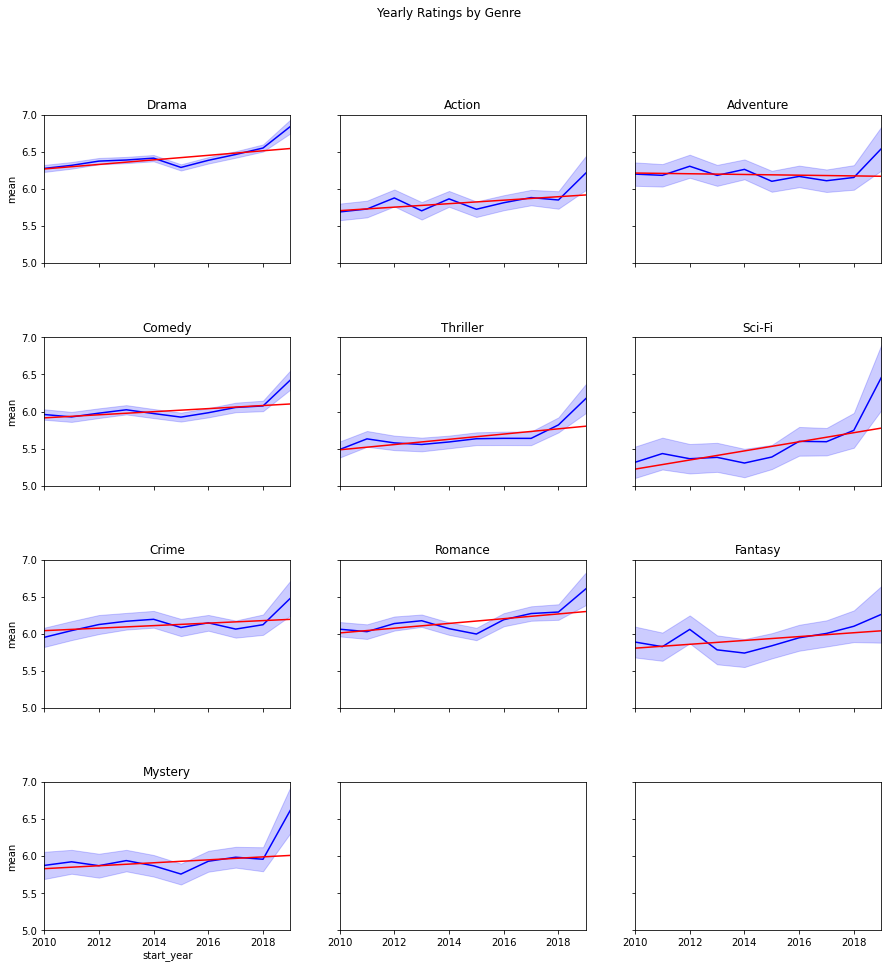

In [16]:
genre_list= list(df_rating['genre'])
#print(genre_list[0])
fig, axs = plot_all_genre_ratings(df_genres, genre_list, color='b', alpha=0.2)
for ax in axs:
    ax.set(xlim=(2010,2019), ylim=(5.0,7.0), yticks=np.arange(5,7.5,0.5))
    
plt.subplots_adjust(hspace=0.5)
fig.suptitle('Yearly Ratings by Genre')
fig.savefig('./images/ratings_by_year.png')

#### Average Rating by Genre & Year

* The above plots show the average movie rating (+/- s.e.m. shown in shading) by year for each movie genre.
* From this, we can see that among the 4 most reviewed movie genres, Drama, Adventure, and Comedy have the highest average ratings, and ratings for Drama and Comedy have been trending upward over recent years (linear regression line shown in red).
* Action movies have a significantly lower average rating.

-------------------------

### Total Domestic Profits and Production Costs, by genre

We will look at which genres yielded the greatest total sum domestic profits.


In [17]:
# Join revenue databases with genre labels

nchar = 50 #define character number to truncate title to, and store as 'short_title' for joining databases on
df_rev['short_title'] = df_rev['title'].str.slice(0,nchar)
df_genres['primary_title'] = df['primary_title'].apply(lambda x: x.lower()) #make title lowercase
df_genres['short_title'] = df_genres['primary_title'].str.slice(0,nchar)
df_revmerge = pd.merge(df_rev, df_genres, on=['short_title']) #merge genre and revenue data on shortened title
df_revmerge.drop_duplicates(subset=['title'], inplace=True) #drop duplicate info from the merged databases

df_revmerge

,title,domestic_gross,foreign_gross,year,production_budget,roi,domestic_profit,short_title,Documentary,Adventure,...,War,Romance,Mystery,Family,primary_title,movie_id,averagerating,numvotes,start_year,sumrating
0,toy story 3,415000000.0,652000000.0,2010,NaN,NaN,NaN,toy story 3,0,1,...,0,0,0,0,toy story 3,tt0435761,8.3,682218,2010,5662409.4
2,inception,292600000.0,535700000.0,2010,NaN,NaN,NaN,inception,0,1,...,0,0,0,0,inception,tt1375666,8.8,1841066,2010,16201380.8
4,shrek forever after,238700000.0,513900000.0,2010,NaN,NaN,NaN,shrek forever after,0,1,...,0,0,0,0,shrek forever after,tt0892791,6.3,167532,2010,1055451.6
6,the twilight saga: eclipse,300500000.0,398000000.0,2010,NaN,NaN,NaN,the twilight saga: eclipse,0,1,...,0,0,0,0,the twilight saga: eclipse,tt1325004,5.0,211733,2010,1058665.0
8,iron man 2,312400000.0,311500000.0,2010,NaN,NaN,NaN,iron man 2,0,1,...,0,0,0,0,iron man 2,tt1228705,7.0,657690,2010,4603830.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6063,stories of our lives,0.0,0.0,2014,15000.0,-1.000000,-15000.0,stories of our lives,0,0,...,0,0,0,0,stories of our lives,tt3973612,7.5,85,2014,637.5
6064,cure,94596.0,0.0,2001,10000.0,8.459600,84596.0,cure,0,0,...,0,0,0,0,cure,tt1872026,4.9,11,2011,53.9
6065,newlyweds,4584.0,0.0,2012,9000.0,-0.490667,-4416.0,newlyweds,0,0,...,0,0,0,0,newlyweds,tt1880418,6.4,1436,2011,9190.4
6066,red 11,0.0,0.0,2018,7000.0,-1.000000,-7000.0,red 11,0,0,...,0,0,0,0,red 11,tt7837402,5.6,43,2019,240.8


In [104]:
# define a function to get roi and domestic_profits for one genre (ignorning NaN entries)
def pull_rev_by_genre(df, genre_label):
    # inputs: 
    #         df -- revenue dataframe
    #         genre_label -- string containing desired genre
    #
    # outputs:
    #         roi -- roi values for this genre (ignorning NaNs)
    #         domestic_profit -- domestic_profit values for this genre (ignoring NaNs)
    #         production_budget -- production budgets for this genre (ignoring NaNs)
    
    df_subset = df[(df[genre_label]==1) & (df['domestic_gross']>0)] #filter movies based on specified genre and a defined domestic_gross
    df_subset = df_subset[df_subset['roi'].notna()] #keep only the movies with a defined ROI
    
    roi = df_subset['roi']
    domestic_profit = df_subset['domestic_profit']
    production_budget = df_subset['production_budget']
    
    return roi, domestic_profit, production_budget


#define a function to plot domestic profits across genres
def plot_domesticprofits_by_genre(df, genre_list):
    # inputs: 
    #         df -- revenue dataframe
    #         genre_list -- list of strings containing desired genres
    
    profits=[]
    for genre in genre_list:
        roi, domestic_profit, production_budget = pull_rev_by_genre(df, genre)
        profits.append(domestic_profit.sum())
    
    df_summary = pd.DataFrame(data={'genre': genre_list, 'profits': profits})
    fig, ax = plt.subplots(figsize=(6,6))

    ax.bar(df_summary['genre'], df_summary['profits']/1000000)
    ax.set_title('Total Domestic Profits (by genre)')
    ax.set_xlabel('Genre')
    ax.set_ylabel('Profits (in Millions of $)')
    
    return fig, ax, df_summary
    
#define a function to plot production_budgets across genres
def plot_productionbudgets_by_genre(df, genre_list):
    # inputs: 
    #         df -- revenue dataframe
    #         genre_list -- list of strings containing desired genres
    
    budgets=[]
    for genre in genre_list:
        roi, domestic_profit, production_budget = pull_rev_by_genre(df, genre)
        budgets.append(production_budget.sum())
    
    df_summary = pd.DataFrame(data={'genre': genre_list, 'budgets': budgets})
    fig, ax = plt.subplots(figsize=(6,6))

    ax.bar(df_summary['genre'], df_summary['budgets']/1000000)
    ax.set_title('Total Production Budgets (by genre)')
    ax.set_xlabel('Genre')
    ax.set_ylabel('Production Budgets (in Millions of $)')
    
    return fig, ax, df_summary


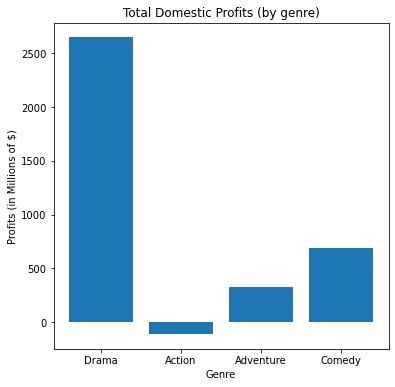

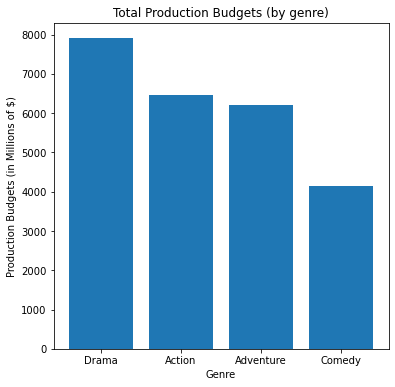

In [106]:
#df_revmerge.sample(10)

fig, ax, df_summary = plot_domesticprofits_by_genre(df_revmerge, ['Drama','Action','Adventure','Comedy'])
fig.savefig('./images/total_domestic_profits_by_genre.png')

fig, ax, df_summary = plot_productionbudgets_by_genre(df_revmerge, ['Drama','Action','Adventure','Comedy'])
fig.savefig('./images/total_production_budget_by_genre.png')

#### Profitability

* Among the 4 most popular genres, Drama and Comedy had the greatest total domestic profits
* Action and Adventure yielded far less total profits (Action being negative due to some movies with large losses)
* This is true despite, the total production costs across the genres being of similar magnitude.

**We recommend a focus on producing Drama and Comedy films to yield better domestic profits.**

-------------------------

### Distribution of Return on Investment (ROI) by genres

We will look at profits in relation to production costs, to determine the genres with the best ROI.

In [227]:

# define function to get roi quartiles 
def get_roi_stats_by_genre(df, genre_label):
  # inputs: 
    #         df -- revenue dataframe
    #         genre_label -- string containing desired genre
    #
    # outputs: 
    #         roi_mean - geometric mean roi value for genre
    #         roi_sem - standard error of roi distribution for the genre
    
    roi, domestic_profit, production_budget = pull_rev_by_genre(df, genre_label)
    roi = roi*100 #convert to percentage ROI value
    
    roi_quartiles = roi.quantile([0.25, 0.5, 0.75])
    
    return roi_quartiles

#define function to plot roi distributions for a list of genres
def plot_roi_stats_by_genres(df, genre_list):
    # inputs: 
    #         df -- revenue dataframe
    #         genre_list -- list of strings containing desired genres
    #
    # outputs: fix, ax -- handles of plot
    #          df_summary -- dataframe with summary stats by genres
    
    fig, ax = plt.subplots(figsize=(6,6))
    
    df_summary = pd.DataFrame()
    
    xtick=1 #to update xtick locations for each plot
    for genre in genre_list:
        roi_quartiles = get_roi_stats_by_genre(df, genre) #pull stats for this genre
        ax.plot(xtick*np.ones(roi_quartiles.shape), roi_quartiles, 'bo-') #plot quartiles
        df_summary[genre] = roi_quartiles #store in dataframe
        xtick = xtick+1
        
    ax.set_title('ROI Distribution (by genre)')
    ax.set_xticks(list(range(1,1+len(genre_list))))
    ax.set_xticklabels(genre_list)
    ax.set_xlabel('Genre')
    ax.set_ylabel('ROI quartiles (25% | 50% | 75%)')
    ax.set_yticks([-100, -50, 0, 50, 100])
    
    return fig, ax, df_summary

,Drama,Action,Adventure,Comedy
0.25,-82.842039,-68.307877,-73.234340,-89.813012
0.50,-23.088827,-31.066488,-30.936386,-24.492850
0.75,108.901487,81.703147,39.917179,87.577254


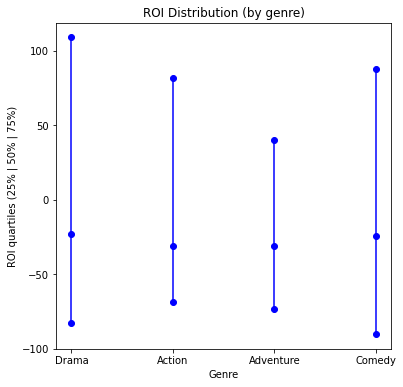

In [228]:
fig, ax, df_summary = plot_roi_stats_by_genres(df_revmerge, ['Drama','Action','Adventure','Comedy'])
fig.savefig('./images/roi_dist_by_genre.png')
df_summary

#### ROI

* All genres had a very wide range of ROI (some movies with negative return and others with positive returns)
* Overall, Drama and Comedy films had higher ROIs (reflected by higher medians and quartiles).

**This analysis reinforces our recommendation that producing Drama and Comedy films would yield the best ROI.**

In [269]:
#define function to analyze roi distributions grouped by production budget range
def get_roi_stats_by_budget(df, genre_list):
    # inputs: 
    #         df -- revenue dataframe
    #         genre_list -- list of strings containing desired genres to collapse over
    #
    # outputs:
    
    df_summary = pd.DataFrame()
    for genre in genre_list:
        roi, domestic_profit, production_budget = pull_rev_by_genre(df, genre) #pull genre data
        this_df = pd.DataFrame(data={'budget': production_budget, 'roi': roi*100})
        df_summary = pd.concat([df_summary, this_df], ignore_index=True)
    
    budget_quartiles = df_summary['budget'].quantile([0, 0.25, 0.5, 0.75, 1]) #get budget quartiles
    
    roi_stats = pd.DataFrame(); #create empty Dataframe

    
    fig, ax = plt.subplots(figsize=(6,6))
    
    for idx in range(4): #loop over quartiles
        
        this_quartile = df_summary[df_summary['budget'].between(budget_quartiles.iloc[idx], budget_quartiles.iloc[idx+1])] #get data for this budget quartile
        
        this_roi_stats = this_quartile['roi'].quantile([0.25, 0.5, 0.75]) #pull roi stats for this quartile
        roi_stats[str(idx+1)] = this_roi_stats #store roi stats in dataframe
        
        ax.plot((idx+1)*np.ones(this_roi_stats.shape), this_roi_stats, 'bo-') #plot quartiles
        
    ax.set_title('ROI Distribution (by production budget range)')
    ax.set_xlabel('Production Budget Quantiles (in millions $)')
    ax.set_ylabel('ROI Quantiles (25% | 50% | 75%)')
    ax.set_yticks([-100, -50, 0, 50, 100, 150])
    ax.set_xlim([0.5, 4.5])
    ax.set_xticks(np.arange(0.5,5,1))
    ax.set_xticklabels([str(x/1000000) for x in budget_quartiles])
    
        
    print([str(x/1000000) for x in budget_quartiles])
        
    return fig, ax, budget_quartiles, roi_stats
        

['0.009', '3.5', '12.0', '30.0', '215.0']


,1,2,3,4
0.25,-94.411100,-93.842375,-74.991467,-56.195928
0.50,-49.066667,-32.690660,2.412541,-20.255431
0.75,73.266275,179.132751,132.907148,36.013964


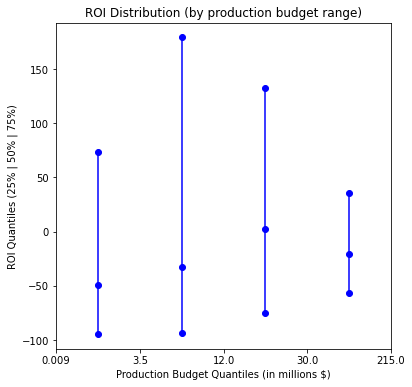

In [272]:
fig, ax, budget_quartiles, roi_stats = get_roi_stats_by_budget(df_revmerge, ['Drama', 'Comedy'])
fig.savefig('./images/roi_dist_by_budget_quartile.png')
roi_stats

#### ROI by production budget range (pooling data across Comedy and Drama genres)

* Middle range production budgets (in the middle two quartiles, between $3.5 - 30 million budgets) had better ROIs than the 1st and 4th quartiles.

**Our client company should focus on producing films in these two genres with moderate budgets to maximize their ROI.**

## Conclusions

These analyses suggest four main recommendations for the company as it enters the commercial film production market.

* They should consider producing films from 4 genres that have the greatest popularity: Drama, Comedy, Action, and Adventure.

* Among these, Drama and Comedy seem the most promising, as they have high average ratings, which are trending upward in recent years.

* To maximize revenue, producing Drama and Comedy films will yield the greatest total profits and ROI.

* Within those genres, the company should focus on producing mid-size budget films, as these yield the greatest ROI.

## Future Steps

Going forward, additional analyses can help identify promising ways to grow the business in a more targeted manner beyond these first steps.

* Identifying if there are significant trends in film profits with regard to release date, to tailor movie release times to maximize revenue.

* Identify individuals (directors, actors, producers) associated with the most profitable films, to curate a more targeted film production pipeline.